### TASK 2. Любым методом спрогнозировать колонку PASSFAIL

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit

from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.utils import resample, shuffle
import itertools
from collections import Counter

In [2]:
data=pd.read_csv("D:/Download/dataset_task2.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Columns: 1000 entries, PASSFAIL to col_999
dtypes: float64(927), int64(72), object(1)
memory usage: 1.8+ MB


In [4]:
data.describe()

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_990,col_991,col_992,col_993,col_994,col_995,col_996,col_997,col_998,col_999
count,210.0,224.0,182.000000,224.000000,224.000000,182.000000,224.000000,224.000000,210.000000,196.000000,...,224.000000,238.000000,196.0,109.000000,210.000000,168.000000,224.000000,210.000000,224.000000,224.000000
mean,1.0,0.0,1.368132,-3.095045,-2.605402,415.835165,-2.725313,-1.941652,-2.914000,483.581633,...,-2.986295,6.993818,1.0,11924.770642,-2.913000,10.951231,-2.735402,-3.060048,-2.590536,-2.695804
std,0.0,0.0,0.483628,0.314960,0.250465,28.751080,0.284088,0.113976,0.281255,31.656141,...,0.305299,16.844814,0.0,380.769996,0.284452,0.731731,0.272392,0.299722,0.251802,0.282186
min,1.0,0.0,1.000000,-3.930000,-3.440000,355.000000,-3.480000,-2.360000,-3.680000,413.000000,...,-3.600000,-48.508500,1.0,10863.000000,-3.760000,9.216648,-3.490000,-3.650000,-3.400000,-3.430000
25%,1.0,0.0,1.000000,-3.310000,-2.762500,395.250000,-2.912500,-2.012500,-3.097500,462.750000,...,-3.210000,-4.921500,1.0,11698.000000,-3.090000,10.365223,-2.942500,-3.247500,-2.750000,-2.900000
50%,1.0,0.0,1.000000,-3.090000,-2.595000,418.000000,-2.700000,-1.930000,-2.915000,485.500000,...,-3.010000,7.762800,1.0,11926.000000,-2.940000,11.080856,-2.705000,-3.105000,-2.580000,-2.680000
75%,1.0,0.0,2.000000,-2.867500,-2.440000,435.000000,-2.520000,-1.860000,-2.710000,503.000000,...,-2.747500,19.257150,1.0,12119.000000,-2.692500,11.580226,-2.550000,-2.850000,-2.407500,-2.497500
max,1.0,0.0,2.000000,-2.370000,-2.030000,500.000000,-1.990000,-1.700000,-2.320000,570.000000,...,-2.260000,40.766400,1.0,13108.000000,-2.270000,12.349022,-2.080000,-2.320000,-1.940000,-2.030000


In [5]:
print("Share of PASS values {:.2%}, share of FAIL values {:.2%} ".format(sum(data["PASSFAIL"]=="PASS")/data.shape[0], 
                                                                         sum(data["PASSFAIL"]=="FAIL")/data.shape[0]))

Share of PASS values 92.86%, share of FAIL values 7.14% 


 In this dataset we have too many features (998) vs observations (238), moreover sample is imbalanced (93% vs 7%). 
The plan is:
- delete constant features with 0 standard deviation, they are not informative
- upsample FAIL class;
- decrease number of features with PCA;
- make classification.



#### Deleting constant features

In [6]:
stds=data.std(axis=0)
stds.shape

(999,)

In [7]:

cols_del_std_0=[]
for index, row in stds.items():
    if  row==0:
        cols_del_std_0.append(index)
print(len(cols_del_std_0))

176


In [8]:
data=data.drop(cols_del_std_0, axis=1)

In [9]:
data.shape

(238, 824)

#### Upsampling

In [10]:
# Separate majority and minority classes
df_major = data[data["PASSFAIL"]=="PASS"]
df_minor = data[data["PASSFAIL"]=="FAIL"]
 

df_minor_upsampled = resample(df_minor, 
                                 replace=True,     
                                 n_samples=df_major.shape[0],    
                                 ) 

df_upsampled = pd.concat([df_major, df_minor_upsampled])
 

df_upsampled["PASSFAIL"].value_counts()


FAIL    221
PASS    221
Name: PASSFAIL, dtype: int64

In [11]:
df_shuffled=shuffle(df_upsampled)
y=df_shuffled["PASSFAIL"]
X=df_shuffled.drop("PASSFAIL",1 )
y=y.replace({"PASS":1, "FAIL":0})
X_=X.fillna(0)

In [12]:
X_.shape

(442, 823)

#### Dimensionality reduction

In [13]:
variance=[]
for i in range(1,20):
    pca=PCA(n_components=i)
    pca.fit(X_)
    variance.append(sum(pca.explained_variance_ratio_))
variance=np.array(variance)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

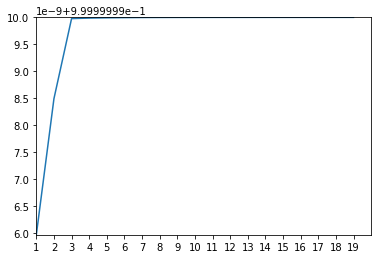

In [14]:
plt.plot(np.arange(1, variance.size+1), variance)
plt.xlim(1,variance.size+1)
plt.ylim(min(variance), max(variance))
plt.xticks(np.arange(1, variance.size+1))
variance

Even with one component explained variance sums to 1, however for better work of  SVC and Random Forest I will take 2 features, (and 20 features just for a check of classification improvement).

In [15]:
pca20=PCA(n_components=20)
pca2=PCA(n_components=2)
X_reduced_20=pca20.fit_transform(X_)
X_reduced_1=pca2.fit_transform(X_)

#### Classification

In [16]:
classifiers={RandomForestClassifier(),
             KNeighborsClassifier(),
             SVC(),
             LogisticRegression()
             }
X_train2, X_test2, y_train2, y_test2=train_test_split(X_reduced_1, y, test_size=0.3, shuffle=True)
X_train20, X_test20, y_train20, y_test20=train_test_split(X_reduced_20, y, test_size=0.3, shuffle=True)

In [18]:
result=pd.DataFrame(columns=["Classifier",  "Accuracy_2 components", "Accuracy_20 components"])
for clf in classifiers:
    cv2=cross_val_score(clf, X_train2, y_train2, cv=StratifiedShuffleSplit(test_size=0.3), scoring="accuracy", n_jobs=-1)
    cv20=cross_val_score(clf, X_train20, y_train20, cv=StratifiedShuffleSplit(test_size=0.3), scoring="accuracy", n_jobs=-1)
    entry=pd.DataFrame([[clf.__class__.__name__,  cv2.mean(), cv20.mean()]],
                           columns=["Classifier",  "Accuracy_2 components", "Accuracy_20 components"])
   
    result=result.append(entry, ignore_index=True)
result=result.sort_values("Accuracy_20 components", ascending=False).reset_index(drop=True)
result

,Classifier,Accuracy_2 components,Accuracy_20 components
0,SVC,0.993548,1.000000
1,RandomForestClassifier,0.887097,0.943011
2,KNeighborsClassifier,0.752688,0.768817
3,LogisticRegression,0.529032,0.525806


Below I have checked test sample & quality of classification for SVC as a best estimator with n_components=2. Accuracy is maximum.

In [19]:
svc2=SVC()
svc2.fit(X_train2, y_train2)
print(metrics.classification_report(svc2.predict(X_test2), y_test2))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        66
          1       1.00      1.00      1.00        67

avg / total       1.00      1.00      1.00       133



In [20]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[66  0]
 [ 0 67]]


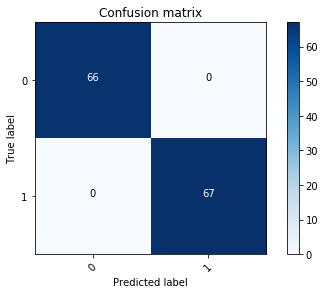

In [21]:
cm=metrics.confusion_matrix(svc2.predict(X_test2), y_test2)
plot_confusion_matrix(cm, classes=[0,1])